## Hyperparameter Tuning
This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations. (Marc Lenz, 2021)

-------------------------------------------------

**General Information**
- Inside this Notebook, different methods to create multilingual document representations are tested and evaluated. 

- Which methods, parameter-settings and languages are used for the evaluation can be adjusted by changing the variables in the Cell below. 

- This Notebook was run in Google Colab. 

**About the Methods and Datasets**

Datasets: 
 - JRC-Arquis (sample of 5000 Documents)
 - EU-Bookshop (sample of ~9000 Documents, first 5000 are selected)

Methods:

- Methods which are based on creating mappings between monolingual corpora.
Those methods are: Linear Concept Approximation (LCA), Linear Concept Compression(LCC) and the Neural Network versions of those: NNCA and NNCC. 
For them, first the monolingual representation have to be created, then the mapping can be applied. Algorithms which are applied here to derive monolingual representations are: Latent Semantic indexing and Doc2Vec (Mikolov et al.)

- Methods which derive multilingual representations directly. Those are: Cross-Lingual Latent Semantic Indexing (CL-LSI) and the improved version of it, which is also described within the theoretical section of the Thesis. 

In [ ]:
"""
----
Languages Preprocessed for JRC_Arquis: en, hu, fr, de, nl, pt, cz, pl
Languages Preprocessed for EU-Bookshop: en, es, fr

"""
#Choose either "JRC_Arquis" "EU-Bookshop"
dataset = "EU-Bookshop" 

#Determines which methods are tested
# True -> Method is evaluated
# False -> Method is ignored
test_LCA = True
test_LCC = True
test_CLLSI = False
test_neural_networks = True

#Set languages, dimensions and kind of monolingual embedding
#The monolingual embedding method influences the results of 
# LCA, LCC, NNCA, and NNCC
languages = ["en", "fr", "es"]
dimensions = [50, 100, 200,  500, 800,  1600]
embedding_method = "Doc2Vec"

#If any other dimensions should be tested for certain models, specify here
lca_dimensions = dimensions
lcao_dimensions = dimensions
lcc_dimensions = dimensions
cllsi_dimensions = dimensions
nn_dimensions = dimensions


##  Load Dataset
- First of all, clone the git repository which contains most of the functions and models for this Notebook

In [ ]:
!git clone https://github.com/marc-lenz/thesis_code.git

fatal: destination path 'thesis_code' already exists and is not an empty directory.


- then load the Dataset

In [ ]:
from google.colab import drive
import pandas as pd 
import numpy as np
import pickle

drive.mount("/content/gdrive")

if dataset == "JRC_Arquis" :
  main_dir = "/content/gdrive/My Drive/Thesis/JRC_Arquis_files/"
  sample_df = pd.read_pickle(main_dir+"sample_df_preprocessed.pkl")
  train_df = sample_df[:3000]
  val_df = sample_df[3000:4000]
  test_df = sample_df[4000:5000]
  
elif dataset == "EU-Bookshop": 
  main_dir = "/content/gdrive/My Drive/Thesis/EU-BookShop Files/"
  #define

  def get_eub_dataframe(main_dir):
    def load(filepath):
      with open(filepath,"rb") as f:
          obj = pickle.load(f)
      return obj
    tokenized_en = load(main_dir+"/tokenized_en.list")
    tokenized_fr = load(main_dir+"/tokenized_fr.list")
    tokenized_es = load(main_dir+"/tokenized_es.list")
    sample_df = pd.DataFrame()
    sample_df["body_pre_en"] = tokenized_en
    sample_df["body_pre_fr"] = tokenized_fr
    sample_df["body_pre_es"] = tokenized_es
    #erase empty lists
    for key in sample_df.keys():
      sample_df = sample_df[sample_df.astype(str)[key] != '[]']
    return sample_df

  sample_df = get_eub_dataframe(main_dir)[:5000]
  train_df = sample_df[:3000]
  val_df = sample_df[3000:4000]
  test_df = sample_df[4000:5000]

Mounted at /content/gdrive


In [ ]:
sample_df

,body_pre_en,body_pre_fr,body_pre_es
0,"[membership, of, parliament, see, minutes]","[composition, du, parlement, voir]","[composición, del, parlamento, véase, el, acta]"
1,"[human, rights, in, the, world, and, the, eu, ...","[droits, de, dans, le, monde, en, politique, d...","[derechos, humanos, en, el, mundo, en, y, polí..."
2,"[composition, of, committees, and, delegations...","[composition, des, commissions, et, des, délég...","[composición, de, las, comisiones, y, delegaci..."
3,"[seventh, human, rights, council, of, the, uni...","[septième, conseil, des, droits, de, des, nati...","[séptimo, consejo, de, derechos, humanos, de, ..."
4,"[sustainable, european, transport, policy, tak...","[la, politique, européenne, du, transport, dur...","[políticas, europeas, de, la, energía, y, del,..."
...,...,...,...
5016,"[transatlantic, relations, debate, the, next, ...","[relations, transatlantiques, débat, du, jour,...","[relaciones, transatlánticas, debate, de, conf..."
5017,"[food, prices, in, europe, before, the, vote, ...","[prix, des, denrées, alimentaires, en, europe,...","[precios, de, los, productos, alimenticios, en..."
5018,"[the, method, as, a, management, tool, for, al...","[outil, de, gestion, pour, des, ressources, bu...","[instrumento, de, gestión, para, la, adjudicac..."
5019,"[general, product, safety, and, market, survei...","[sécurité, générale, des, produits, et, survei...","[seguridad, general, de, los, productos, y, vi..."


## Train Monolingual Representations which will be aligned
- > Define the languages and dimensions which should be tested here

In [ ]:
from thesis_code.Utils import read_docs, Vector_Lsi_Model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm 

max_dim = max(dimensions)
matrices = dict()


if embedding_method == "LSI":
  lsi_models = dict()
  for t in languages:
    key = "body_pre_{}".format(t)
    lsi_models[t] = Vector_Lsi_Model(sample_df[key], dimension=max_dim)
    matrices["{}_train_vecs".format(t)] = np.asarray(lsi_models[t].create_embeddings(train_df[key]))
    matrices["{}_val_vecs".format(t)] = np.asarray(lsi_models[t].create_embeddings(test_df[key]))

elif embedding_method =="Doc2Vec":
  for dimension in dimensions:
    matrices[dimension] = dict()
    for t in tqdm(languages):
      key = "body_pre_{}".format(t)
      #create tagged docs first
      documents = []
      for ind in sample_df.index:
        doc = sample_df[key][ind]
        tagged_doc = TaggedDocument(doc, [ind])
        documents.append(tagged_doc)
      #Train Doc2Vec Model
      model = Doc2Vec(documents, vector_size=dimension, window=4, min_count=5, workers=4, epochs=100, dm=0)
      training_docs = [model[i] for i in train_df.index]
      validation_docs = [model[i] for i in val_df.index]
      test_docs = [model[i] for i in test_df.index]
      #set matrices
      matrices[dimension]["{}_train_vecs".format(t)] = np.asarray(training_docs)
      matrices[dimension]["{}_val_vecs".format(t)] = np.asarray(validation_docs)
      matrices[dimension]["{}_test_vecs".format(t)] = np.asarray(test_docs)

 67%|██████▋   | 2/3 [1:02:50<31:17, 1877.24s/it]

In [ ]:
with open(main_dir+"MATRICES__EUB", 'wb') as handle:
    pickle.dump(matrices, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from itertools import permutations
pairs = permutations(languages, 2)
pair_list = [p for p in pairs]

## Linear Concept Approximation

In [ ]:
import numpy as np
import scipy as sp
from tqdm import tqdm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from functools import partial
from itertools import combinations
from gensim import corpora, models, matutils

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from gensim import models
import itertools
from thesis_code.Utils import create_corpus, read_docs, mate_retrieval_score

import pickle

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import regularizers

def plot_parameter_graph(dimensions, scores, title, xlabel = "Dimensions", ylabel = "Reciprocal Rank", pair_list=None):
  figure(figsize=(9, 6))

  for k, score in enumerate(scores):
    if pair_list == None:
        plt.plot(dimensions, scores[k], alpha=0.8, label="Language Pair: {}".format(k))
    else:
        plt.plot(dimensions, scores[k], alpha=0.8, label="Language Pair: {} -> {}".format(pair_list[k][0], pair_list[k][1]))
  avg = np.mean(np.asarray(scores), axis=0)
  plt.plot(dimensions, avg, c="r", label="Average Score",linewidth=3.0)

  max_ind = np.argmax(avg)

  plt.scatter(dimensions[max_ind], avg[max_ind], c="k")
  plt.text(dimensions[max_ind], avg[max_ind]-0.03, 
          "Dimension: {} \nMean Score: {}".format(dimensions[max_ind],str(avg[max_ind])[:4] ),
          fontsize= 12
              )
  plt.title(title, fontsize=13)
  plt.xlabel("Dimensions")
  plt.ylabel("Reciprocal Rank")
  #plt.ylim(0.85,1)
  plt.legend()
  plt.show()

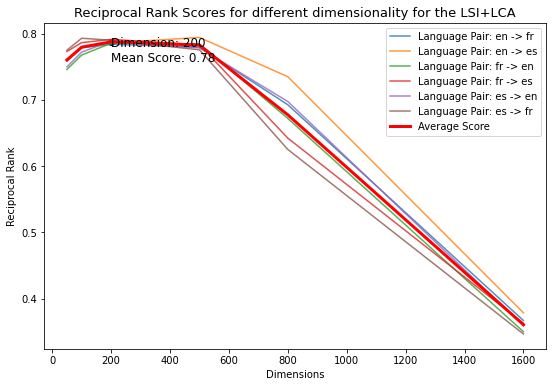

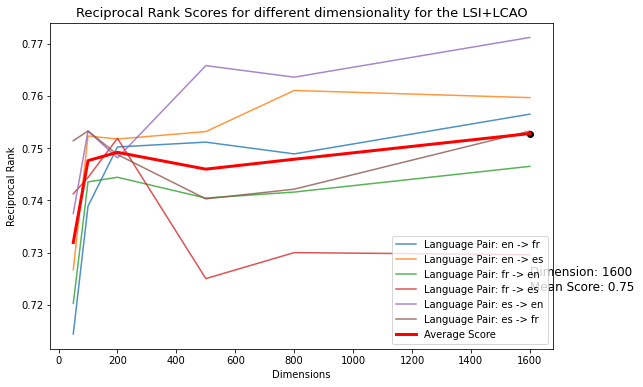

In [ ]:
from thesis_code.evaluation_functions import evaluate_baseline_lca_model, evaluate_baseline_lca_model_ort
from thesis_code.evaluation_functions import mate_retrieval, reciprocal_rank
from tqdm import tqdm

if test_LCA == True:
  lca_scores = []
  lcao_scores = []

  for pair in pair_list:
    l1 = pair[0]
    l2 = pair[1]
    if embedding_method == "LSI":
      l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_val_vecs".format(l1)]
      l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_val_vecs".format(l2)]
      score_lca = evaluate_baseline_lca_model(l1_train, l1_test, l2_train, l2_test, dimensions, reciprocal_rank)
      score_lcao = evaluate_baseline_lca_model_ort(l1_train, l1_test, l2_train, l2_test, dimensions, reciprocal_rank)
    if embedding_method =="Doc2Vec":
      score_lca = []
      score_lcao = []
      for dimension in dimensions: 
        l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
        l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
        score_lca.append(evaluate_baseline_lca_model(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])
        score_lcao.append(evaluate_baseline_lca_model_ort(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])


    lca_scores.append(score_lca)
    lcao_scores.append(score_lcao )

  #from thesis_code.evaluation_functions  import plot_parameter_graph
  title_lca = "Reciprocal Rank Scores for different dimensionality for the LSI+LCA"
  title_lcao = "Reciprocal Rank Scores for different dimensionality for the LSI+LCAO"

  plot_parameter_graph(dimensions, lca_scores, title = title_lca, pair_list=pair_list)
  plot_parameter_graph(dimensions, lcao_scores, title = title_lcao, pair_list=pair_list)

##LCC Scores

In [ ]:
from thesis_code.evaluation_functions import evaluate_lcc_model

if test_LCC == True:
  lcc_scores = []

  for pair in pair_list:
    l1 = pair[0]
    l2 = pair[1]
    if embedding_method =="LSI":
      l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_val_vecs".format(l1)]
      l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_val_vecs".format(l2)]
      score_lcc = evaluate_lcc_model(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
    if embedding_method =="Doc2Vec":
      score_lcc = []
      for dimension in dimensions: 
        l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
        l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
        score_lcc.append(evaluate_lcc_model(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])
    lcc_scores.append(score_lcc)   

  title_lcc = "Reciprocal Rank Scores for different dimensionality for LSI+LCC"
  plot_parameter_graph(dimensions, lcc_scores, title = title_lcc, pair_list=pair_list)

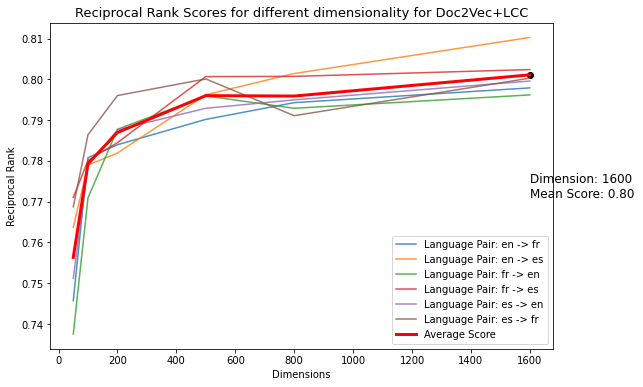

In [ ]:

title_lcc = "Reciprocal Rank Scores for different dimensionality for Doc2Vec+LCC"
plot_parameter_graph(dimensions, lcc_scores, title = title_lcc, pair_list=pair_list)

#Cross-Lingual LSI

In [ ]:
from thesis_code.evaluation_functions import evaluate_cllsi, evaluate_improved_cllsi
from tqdm import tqdm
if True:
  cllsi_scores = []
  i_cllsi_scores = []

  for pair in tqdm(pair_list):
    l1 = pair[0]
    l2 = pair[1]
    l1_train, l1_test = list(train_df["body_pre_{}".format(l1)]), list(val_df["body_pre_{}".format(l1)])
    l2_train, l2_test = list(train_df["body_pre_{}".format(l2)]), list(val_df["body_pre_{}".format(l2)])
    cllsi_score = evaluate_cllsi(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
    print("pair: {}, CL-LSI score: {}".format(pair, cllsi_score) )
    i_cllsi_score = evaluate_improved_cllsi(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
    print("pair: {}, CL-LSI score: {}".format(pair, i_cllsi_score))
    cllsi_scores.append(cllsi_score)
    i_cllsi_scores.append(i_cllsi_score)

  title_cllsi = "Reciprocal Rank Scores for different dimensionality for the CL-LSI"
  title_i_cllsi = "Reciprocal Rank Scores for different dimensionality for the improved CL-LSI "
  plot_parameter_graph(dimensions, cllsi_scores, title = title_cllsi, pair_list=pair_list)
  plot_parameter_graph(dimensions, i_cllsi_scores, title = title_i_cllsi)


  0%|          | 0/6 [00:00<?, ?it/s]

pair: ('en', 'fr'), CL-LSI score: [0.327014984281095, 0.4605591138398254, 0.5852961206501567, 0.6422910717014708, 0.653947207593432, 0.6620348040105503]


 17%|█▋        | 1/6 [19:07<1:35:35, 1147.08s/it]

pair: ('en', 'fr'), CL-LSI score: [0.43186454195218754, 0.5257376780743979, 0.5982525912121777, 0.591393737649227, 0.5221121690277559, 0.1177802516536594]


KeyboardInterrupt: ignored

##Neural Networks 

List all settings to be tested here. 

In [ ]:
settings_nncc =  [         
            {"dimension" : 1200,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "MSE"},

            {"dimension" : 1200,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            {"dimension" : 800,
             "neurons" : [2000,50,2000], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            {"dimension" : 500,
             "neurons" : [500], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
              {"dimension" : 500,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"}           ]     



"""
[#Setting 1
            {"dimension" : 200,
             "neurons" : [200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "MSE"},
             #Setting 2
            {"dimension" : 200,
             "neurons" : [200, 100, 200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 3
            {"dimension" : 200,
             "neurons" : [1000, 200, 1000], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "sgd",
             "loss_function" : "cosine_sim"},
             #Setting 4
            {"dimension" : 200,
             "neurons" : [200], 
             "activation_function" : None,
             "dropout" : 0.1,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            #Setting 5
            {"dimension" : 200,
             "neurons" : [200, 100, 200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 6
            {"dimension" : 200,
             "neurons" : [50], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 7
            {"dimension" : 200,
             "neurons" : [100, 50, 100], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"}
             ]

"""

In [ ]:
settings_nnca = [            {"dimension" : 1200,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "MSE"},

            {"dimension" : 1200,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            {"dimension" : 800,
             "neurons" : [2000,2000,2000], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            {"dimension" : 500,
             "neurons" : [500], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
              {"dimension" : 500,
             "neurons" : [300], 
             "activation_function" : None,
             "dropout" : 0.0,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"}       

             ]             
  



"""
                 #Setting 1
            {"dimension" : 200,
             "neurons" : [200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "MSE"},
             #Setting 2
            {"dimension" : 200,
             "neurons" : [200, 100, 200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 3
            {"dimension" : 200,
             "neurons" : [1000, 200, 1000], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "sgd",
             "loss_function" : "cosine_sim"},
             #Setting 4
            {"dimension" : 200,
             "neurons" : [200], 
             "activation_function" : None,
             "dropout" : 0.1,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
            #Setting 5
            {"dimension" : 200,
             "neurons" : [200, 100, 200], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 6
            {"dimension" : 200,
             "neurons" : [50], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"},
             #Setting 7
            {"dimension" : 200,
             "neurons" : [100, 50, 100], 
             "activation_function" : "relu",
             "dropout" : 0.2,
             "optimizer" : "adam",
             "loss_function" : "cosine_sim"}
             ]
"""

In [ ]:
from thesis_code.evaluation_functions import evaluate_nncc, evaluate_nnca
scores = []
if True: #test_neural_networks == True:
  #choose only one, to reduce computational burden
  for pair in pair_list[:1]:
    l1 = pair[0]
    l2 = pair[1]
    
    if embedding_method =="LSI":
        for setting in settings_nncc:
          dimension = setting["dimension"]
          l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_val_vecs".format(l1)]
          l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_val_vecs".format(l2)]
          score, history = evaluate_nncc(l1_train, l1_test, l2_train, l2_test, 
                                dimensions = [dimension], 
                                evaluation_function = reciprocal_rank,
                                neurons = setting["neurons"],
                                activation_function = setting["activation_function"],
                                max_epochs = 200,
                                dropout = setting["dropout"],
                                optimizer = setting["optimizer"],
                                loss = setting["loss_function" ])
          scores.append(score[0])
          setting["score"] = score[0]
          setting["loss"] = history.history["loss"][-1]
          setting["val_loss"] = history.history["val_loss"][-1]
          setting["epochs"] = len(history.history["loss"])
        for setting in settings_nnca:
          dimension = setting["dimension"]
          l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_val_vecs".format(l1)]
          l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_val_vecs".format(l2)]
          score, h1, h2 = evaluate_nnca(l1_train, l1_test, l2_train, l2_test, 
                                dimensions = [dimension], 
                                evaluation_function = reciprocal_rank,
                                neurons = setting["neurons"],
                                activation_function = setting["activation_function"],
                                max_epochs = 200,
                                dropout = setting["dropout"],
                                optimizer = setting["optimizer"],
                                loss = setting["loss_function" ])
          setting["score"] = score[0]
          setting["score"] = score[0]
          setting["loss"] = h1.history["loss"][-1]
          setting["val_loss"] = h1.history["val_loss"][-1]
          setting["epochs"] = len(h1.history["loss"])
    if embedding_method =="Doc2Vec":
        #Compute score for each nncc Setting:
        for setting in settings_nncc:
          dimension = setting["dimension"]
          l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
          l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
          score, history = evaluate_nncc(l1_train, l1_test, l2_train, l2_test, 
                                dimensions = [dimension], 
                                evaluation_function = reciprocal_rank,
                                neurons = setting["neurons"],
                                activation_function = setting["activation_function"],
                                max_epochs = 200,
                                dropout = setting["dropout"],
                                optimizer = setting["optimizer"],
                                loss = setting["loss_function" ])
          scores.append(score[0])
          setting["score"] = score[0]
          setting["loss"] = history.history["loss"][-1]
          setting["val_loss"] = history.history["val_loss"][-1]
          setting["epochs"] = len(history.history["loss"])
        for setting in settings_nnca:
          dimension = setting["dimension"]
          l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
          l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
          score, h1, h2 = evaluate_nnca(l1_train, l1_test, l2_train, l2_test, 
                                dimensions = [dimension], 
                                evaluation_function = reciprocal_rank,
                                neurons = setting["neurons"],
                                activation_function = setting["activation_function"],
                                max_epochs = 200,
                                dropout = setting["dropout"],
                                optimizer = setting["optimizer"],
                                loss = setting["loss_function" ])
          setting["score"] = score[0]
          setting["score"] = score[0]
          setting["loss"] = h1.history["loss"][-1]
          setting["val_loss"] = h1.history["val_loss"][-1]
          setting["epochs"] = len(h1.history["loss"])

In [ ]:
np.mean(scores)

In [ ]:
column_names = ['activation_function', 'dimension', 'dropout',  
        'neurons','loss_function', 'optimizer', 'epochs','loss', 'val_loss','score']

In [ ]:
nnca_df = pd.DataFrame(columns = column_names)
for setting in settings_nnca:
  nnca_df = nnca_df.append(setting, ignore_index= True)

nncc_df = pd.DataFrame(columns = column_names)
for setting in settings_nncc:
  nncc_df = nncc_df.append(setting, ignore_index= True)

In [ ]:
nnca_df

In [ ]:
nncc_df

In [ ]:
nncc_df.to_latex(index=False)

In [ ]:
nnca_df.to_latex(index=False)